## Convolutional Neural Network (CNN) for Image Classification

### Import necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


### Data Preparation
We will load and split the CIFAR-10 dataset into training, validation, and test sets.

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Split training data into training and validation sets
x_val = x_train[40000:]
y_val = y_train[40000:]
x_train = x_train[:40000]
y_train = y_train[:40000]

# Verify the splits
print(f"Training set size: {x_train.shape[0]}")
print(f"Validation set size: {x_val.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training set size: 40000
Validation set size: 10000
Test set size: 10000


### Define the Base Class for Image Classification
The **ImageClassificationBase** class will contain essential methods for training, evaluating, and reporting results.



In [ ]:
class ImageClassificationBase:
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.learning_rate = learning_rate
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    def fit(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=64):
        history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                                 validation_data=(x_val, y_val),
                                 callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
        return history

    def evaluate(self, x_test, y_test):
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=2)
        return test_loss, test_acc


### Define the CNN Model (Cifar10Model)
Now we define the **Cifar10Model** class, which extends the base class and implements the custom CNN architecture.

In [ ]:
class Cifar10Model(ImageClassificationBase):
    def __init__(self, input_shape=(32, 32, 3), num_classes=10):
        # Define the CNN architecture
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])
        super().__init__(model)



### Define ResNet-18 and DenseNet-121 Models (Pretrained)
We’ll use **ResNet-18** and **DenseNet-121** with weights pre-trained on ImageNet and fine-tune them for CIFAR-10.

In [ ]:
def create_resnet18(input_shape=(32, 32, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze layers for fine-tuning
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_densenet121(input_shape=(32, 32, 3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze layers for fine-tuning
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])
    return model


### Train and Evaluate Models
Now we’ll train the models and evaluate their performance on the test set.

In [ ]:
# Initialize and train the custom CNN model
cnn_model = Cifar10Model(input_shape=(32, 32, 3))
cnn_history = cnn_model.fit(x_train, y_train, x_val, y_val, epochs=10)

# Evaluate CNN Model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test, y_test)
print(f"CNN Test Accuracy: {cnn_test_acc:.4f}")

# Initialize and train ResNet-18 model
resnet_model = ImageClassificationBase(create_resnet18(input_shape=(32, 32, 3)))
resnet_history = resnet_model.fit(x_train, y_train, x_val, y_val, epochs=10)

# Evaluate ResNet-18 Model
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(x_test, y_test)
print(f"ResNet-18 Test Accuracy: {resnet_test_acc:.4f}")

# Initialize and train DenseNet-121 model
densenet_model = ImageClassificationBase(create_densenet121(input_shape=(32, 32, 3)))
densenet_history = densenet_model.fit(x_train, y_train, x_val, y_val, epochs=10)

# Evaluate DenseNet-121 Model
densenet_test_loss, densenet_test_acc = densenet_model.evaluate(x_test, y_test)
print(f"DenseNet-121 Test Accuracy: {densenet_test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.2510 - loss: 1.9955 - val_accuracy: 0.4887 - val_loss: 1.4121
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.4786 - loss: 1.4478 - val_accuracy: 0.5493 - val_loss: 1.2531
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 90ms/step - accuracy: 0.5477 - loss: 1.2640 - val_accuracy: 0.6041 - val_loss: 1.1316
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.5992 - loss: 1.1317 - val_accuracy: 0.6351 - val_loss: 1.0258
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - accuracy: 0.6357 - loss: 1.0311 - val_accuracy: 0.6553 - val_loss: 0.9792
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.6658 - loss: 0.9583 - val_accuracy: 0.6838 - val_loss: 0.9113
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.6850 - loss: 0.8996 - val_accuracy: 0.6839 - val_loss: 0.9119
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.7006 - loss: 0.8642 - 

### Plot Training and Validation Metrics
After training each model, plotting the accuracy and loss curves to compare the training progress.

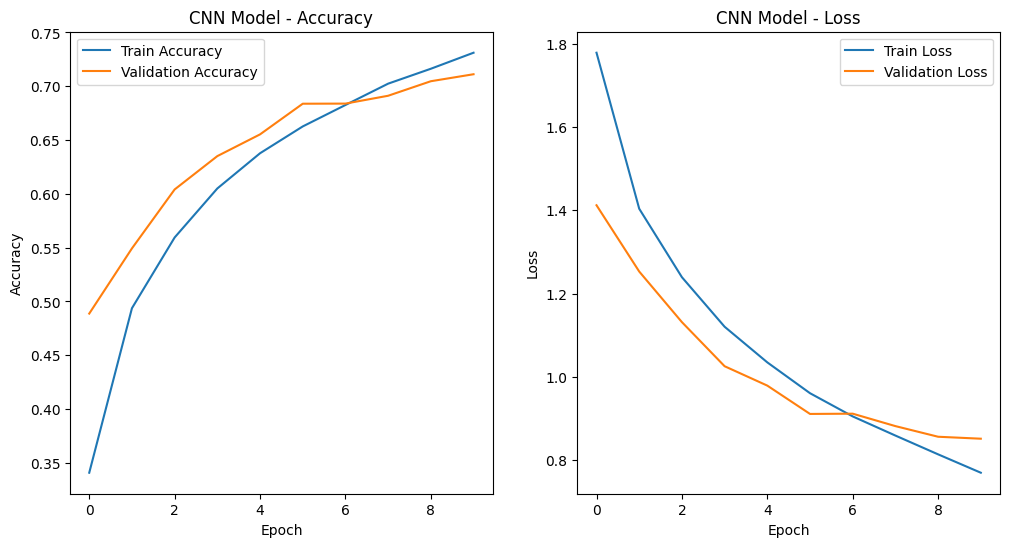

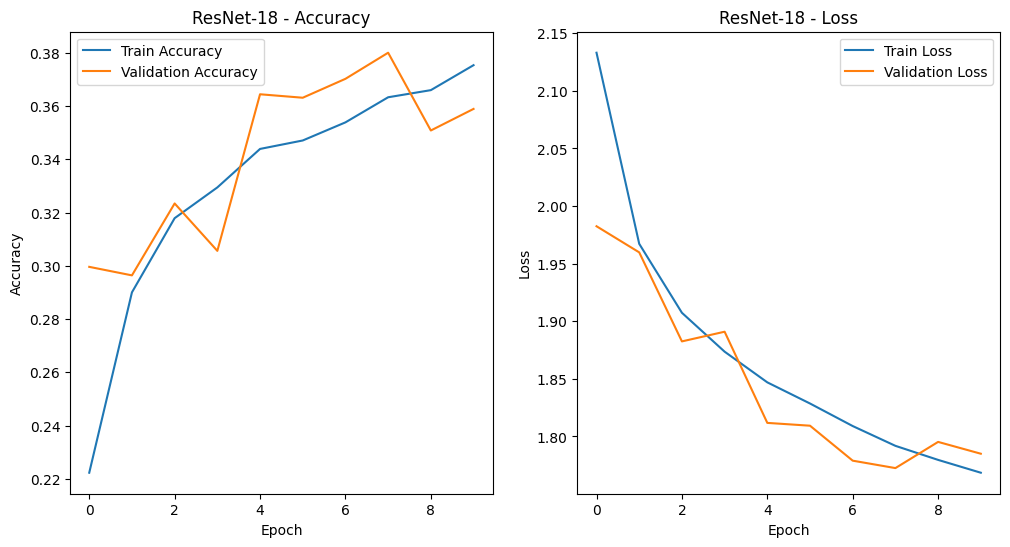

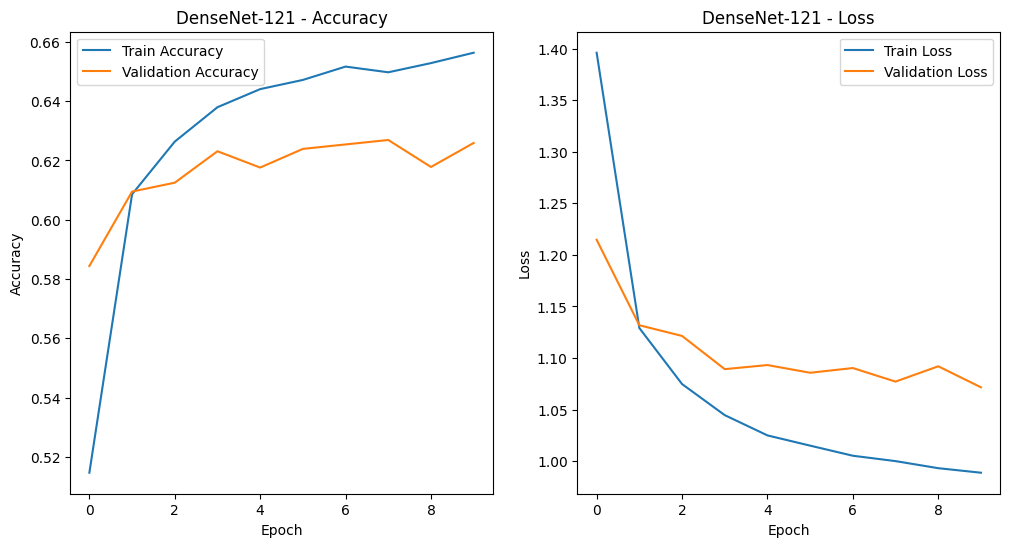

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot results for each model
plot_history(cnn_history, "CNN Model")
plot_history(resnet_history, "ResNet-18")
plot_history(densenet_history, "DenseNet-121")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 101ms/step - accuracy: 0.3232 - loss: 1.8320 - val_accuracy: 0.5185 - val_loss: 1.3330
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - accuracy: 0.5424 - loss: 1.2838 - val_accuracy: 0.5796 - val_loss: 1.1988
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - accuracy: 0.6122 - loss: 1.0885 - val_accuracy: 0.6281 - val_loss: 1.0540
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.6582 - loss: 0.9775 - val_accuracy: 0.6136 - val_loss: 1.1067
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.6845 - loss: 0.8982 - val_accuracy: 0.6697 - val_loss: 0.9425
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.7089 - loss: 0.8283 - val_accuracy: 0.6582 - val_loss: 0.9853
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.7292 - loss: 0.7771 - val_accuracy: 0.6784 - val_loss: 0.9256
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.7482 - loss: 0.7222 -

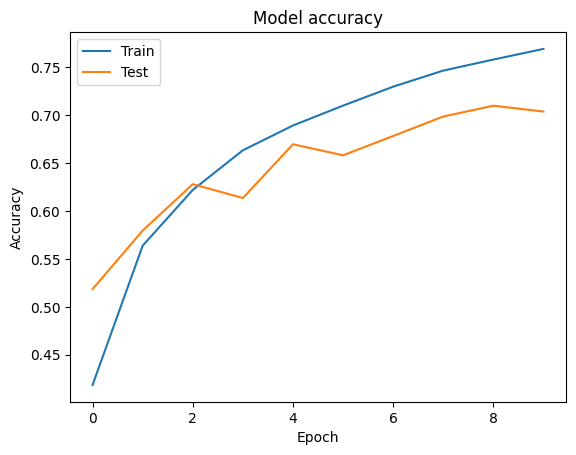

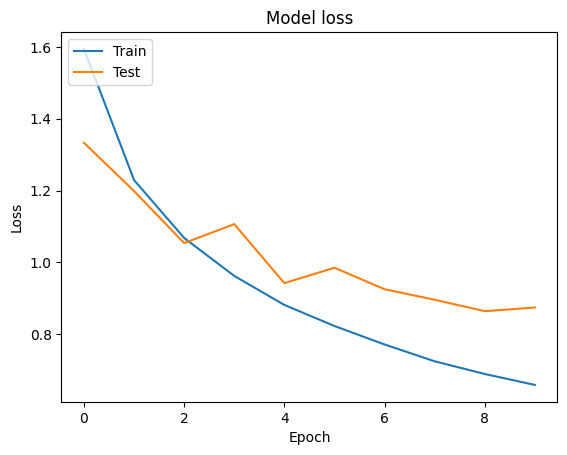

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Resizing Input Images Before Feeding to the Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a new data generator with resizing
datagen = ImageDataGenerator(rescale=1./255)

# Use the generator to resize images if needed
train_generator = datagen.flow(x_train, y_train, batch_size=64)
validation_generator = datagen.flow(x_val, y_val, batch_size=64)

# Ensure input shape is large enough
input_shape = (32, 32, 3)  # Adjust if necessary

# Adjust model architectures if necessary based on the output shape


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 1.3583, Accuracy: 50.82%
Epoch [2/10], Loss: 1.0011, Accuracy: 64.49%
Epoch [3/10], Loss: 0.8601, Accuracy: 69.68%
Epoch [4/10], Loss: 0.7531, Accuracy: 73.56%
Epoch [5/10], Loss: 0.6600, Accuracy: 76.69%
Epoch [6/10], Loss: 0.5835, Accuracy: 79.38%
Epoch [7/10], Loss: 0.5083, Accuracy: 82.10%
Epoch [8/10], Loss: 0.4440, Accuracy: 84.23%
Epoch [9/10], Loss: 0.3898, Accuracy: 86.20%
Epoch [10/10], Loss: 0.3440, Accuracy: 87.69%
Test Accuracy: 74.12%


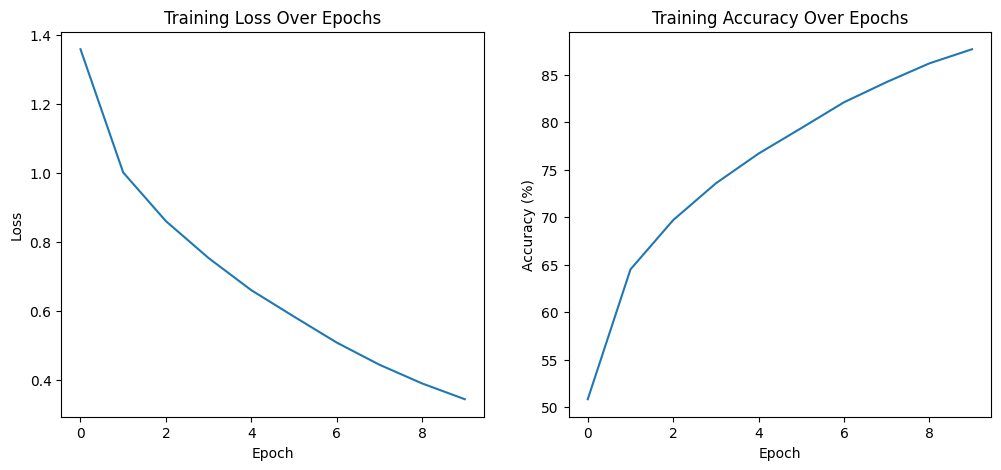

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Define the CNN model
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()

        # Convolutional Layer 1: 3 input channels (RGB), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Convolutional Layer 2: 32 input channels, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Max-pooling layer with 2x2 kernel
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Flatten 8x8x64 features to 512
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply first convolution, ReLU activation, and max-pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolution, ReLU activation, and max-pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 8 * 8)

        # Apply the first fully connected layer and dropout
        x = self.dropout(F.relu(self.fc1(x)))

        # Apply the second fully connected layer to get the output
        x = self.fc2(x)

        return x

# Instantiate the model, define loss function and optimizer
model = CIFAR10Model()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, trainloader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Compute running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies

# Evaluation function
def evaluate_model(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Train the model
train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, num_epochs=10)

# Evaluate the model
test_accuracy = evaluate_model(model, testloader)

# Plot the training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic Block for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut/Skip Connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Skip connection
        out = F.relu(out)
        return out

# ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Create the model
resnet18_model = ResNet18(num_classes=10)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(self._make_layer(in_channels, growth_rate))
            in_channels += growth_rate

    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        for layer in self.layers:
            new_features = layer(x)
            x = torch.cat([x, new_features], 1)  # Concatenate along the channel dimension
        return x

# Transition Layer (downsampling)
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.pool(x)
        return x

# DenseNet-121 Model
class DenseNet121(nn.Module):
    def __init__(self, num_classes=10):
        super(DenseNet121, self).__init__()

        # Initial Convolution Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Dense Blocks and Transition Layers
        self.dense_block1 = DenseBlock(64, 32, 6)  # Growth rate = 32, 6 layers
        self.transition1 = TransitionLayer(64 + 6 * 32, 128)

        self.dense_block2 = DenseBlock(128, 32, 12)  # Growth rate = 32, 12 layers
        self.transition2 = TransitionLayer(128 + 12 * 32, 256)

        self.dense_block3 = DenseBlock(256, 32, 24)  # Growth rate = 32, 24 layers
        self.transition3 = TransitionLayer(256 + 24 * 32, 512)

        self.dense_block4 = DenseBlock(512, 32, 16)  # Growth rate = 32, 16 layers

        # Fully Connected Layer
        self.fc = nn.Linear(512 + 16 * 32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.dense_block1(x)
        x = self.transition1(x)

        x = self.dense_block2(x)
        x = self.transition2(x)

        x = self.dense_block3(x)
        x = self.transition3(x)

        x = self.dense_block4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)

        x = self.fc(x)
        return x

# Create the model
densenet121_model = DenseNet121(num_classes=10)


## ResNet18 Model for CIFAR10 Data set

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 1.4058, Train Accuracy: 49.46%
Validation Loss: 1.1801, Validation Accuracy: 58.96%
Epoch [2/10], Train Loss: 1.0250, Train Accuracy: 63.95%
Validation Loss: 0.9976, Validation Accuracy: 65.64%
Epoch [3/10], Train Loss: 0.8343, Train Accuracy: 70.64%
Validation Loss: 0.8210, Validation Accuracy: 72.04%
Epoch [4/10], Train Loss: 0.7131, Train Accuracy: 75.10%
Validation Loss: 0.7954, Validation Accuracy: 72.36%
Epoch [5/10], Train Loss: 0.6089, Train Accuracy: 78.87%
Validation Loss: 0.7700, Validation Accuracy: 73.98%
Epoch [6/10], Train Loss: 0.5173, Train Accuracy: 81.92%
Validation Loss: 0.7991, Validation Accuracy: 73.28%
Epoch [7/10], Train Loss: 0.4235, Train Accuracy: 85.20%
Validation Loss: 0.7319, Validation Accuracy: 76.30%
Epoch [8/10], Train Loss: 0.3502, Train Accuracy: 87.78%
Validation Loss: 0.7898, Validation Accuracy: 75.22%
Epoch [9/10], Train Loss: 0.2786, Train Accuracy: 90.25%
Validation Loss: 0.7926, Validation Accuracy: 76.70%
Epoch [10/

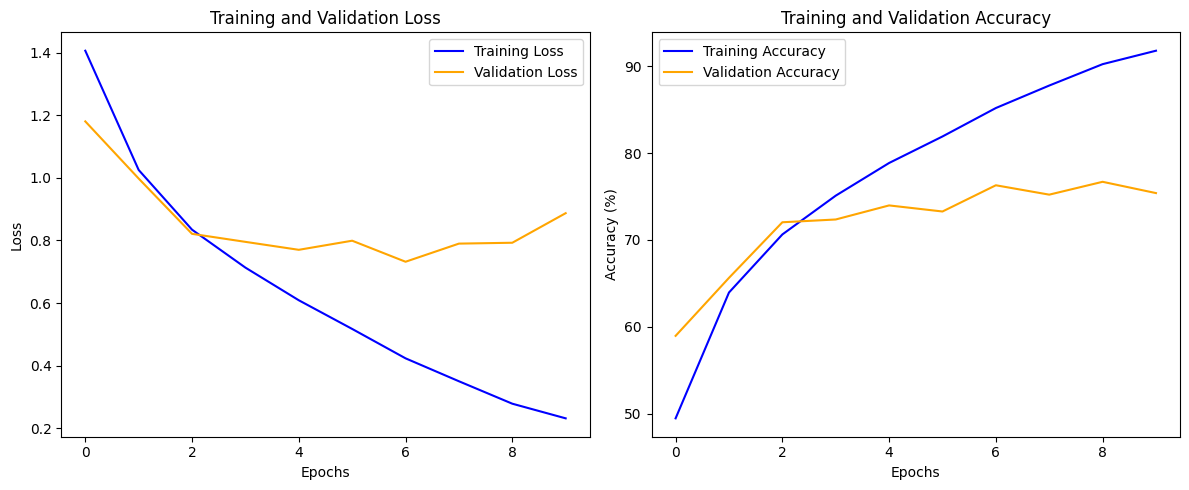

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.data import random_split

# Hyperparameters
epochs = 10
learning_rate = 0.001
batch_size = 64

# Define a transform to normalize the CIFAR-10 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training set into training and validation sets
train_size = int(0.9 * len(trainset))  # 90% for training
val_size = len(trainset) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define ResNet-18 model for CIFAR-10
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        # Load ResNet-18 from torchvision, but without pre-trained weights
        self.resnet = models.resnet18(pretrained=False)
        # Modify the last fully connected layer to output 10 classes (for CIFAR-10)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = ResNet18(num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store the loss and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

        # Accuracy calculation
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == targets).item()
        total_train += targets.size(0)

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            running_val_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == targets).item()
            total_val += targets.size(0)

    # Calculate average validation loss and accuracy
    val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot Loss and Accuracy curves
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Loss Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the loss and accuracy
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


## DenseNet121 model for CIFAR10 Data set

100%|██████████| 170M/170M [00:06<00:00, 27.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 1.4036, Train Accuracy: 49.24%
Validation Loss: 1.1723, Validation Accuracy: 58.34%
Epoch [2/10], Train Loss: 1.0094, Train Accuracy: 64.14%
Validation Loss: 0.9840, Validation Accuracy: 65.64%
Epoch [3/10], Train Loss: 0.8186, Train Accuracy: 71.45%
Validation Loss: 0.9004, Validation Accuracy: 69.64%
Epoch [4/10], Train Loss: 0.6856, Train Accuracy: 76.05%
Validation Loss: 0.7621, Validation Accuracy: 73.72%
Epoch [5/10], Train Loss: 0.5759, Train Accuracy: 80.09%
Validation Loss: 0.7737, Validation Accuracy: 73.82%
Epoch [6/10], Train Loss: 0.4848, Train Accuracy: 83.00%
Validation Loss: 0.9468, Validation Accuracy: 70.42%
Epoch [7/10], Train Loss: 0.4737, Train Accuracy: 83.54%
Validation Loss: 0.8366, Validation Accuracy: 72.78%
Epoch [8/10], Train Loss: 0.4373, Train Accuracy: 84.98%
Validation Loss: 0.7520, Validation Accuracy: 76.56%
Epoch [9/10], Train Loss: 0.2842, Train Accuracy: 90.11%
Validation Loss: 0.8014, Validation Accuracy: 76.02%
Epoch [10/

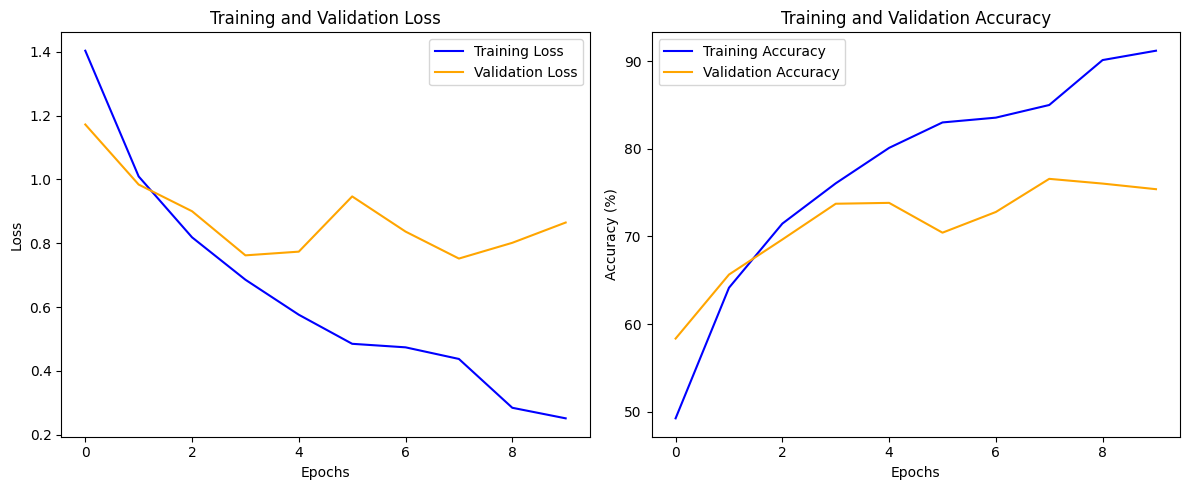

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.data import random_split

# Hyperparameters
epochs = 10
learning_rate = 0.001
batch_size = 64

# Define a transform to normalize the CIFAR-10 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training set into training and validation sets
train_size = int(0.9 * len(trainset))  # 90% for training
val_size = len(trainset) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define DenseNet-121 model for CIFAR-10
class DenseNet121(nn.Module):
    def __init__(self, num_classes=10):
        super(DenseNet121, self).__init__()
        # Load DenseNet-121 from torchvision, but without pre-trained weights
        self.densenet = models.densenet121(pretrained=False)
        # Modify the last fully connected layer to output 10 classes (for CIFAR-10)
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)

    def forward(self, x):
        return self.densenet(x)

# Instantiate the model
model = DenseNet121(num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store the loss and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

        # Accuracy calculation
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == targets).item()
        total_train += targets.size(0)

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            running_val_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == targets).item()
            total_val += targets.size(0)

    # Calculate average validation loss and accuracy
    val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot Loss and Accuracy curves
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Loss Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the loss and accuracy
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
